In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import re
import os
import sys
import shutil
from shutil import copyfile, copy2
from shutil import move

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import seaborn as sns
from scipy import stats
# Cause plots to be displayed in the notebook:
%matplotlib inline

In [5]:
import subprocess 

In [6]:
from matplotlib import cm
from latt2D_modules import calc_diffuse
from latt2D_modules import get_occ_map, get_2D_occ_map_from_seq,store_occ_map_as_seq
from latt2D_modules import plot_occ_map,read_bin,output_16bit_pgm
import time

In [7]:
from tensorflow import keras
from tensorflow.keras import layers


2023-05-08 09:59:46.730732: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [8]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from keras.metrics import MeanSquaredError, MeanAbsoluteError, MeanAbsolutePercentageError, RootMeanSquaredError
from sklearn.metrics import r2_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
import h5py
from keras.callbacks import ModelCheckpoint

In [9]:
df=pd.read_csv('output_correlations_1000.csv')
y=df.iloc[:,2:5].values

In [68]:
df.head(10)

,Unnamed: 0,00,01,10,11
0,0,0.997379,-0.671421,0.314179,-0.626621
1,1,0.999959,-0.016041,-0.889641,0.087959
2,2,0.999498,-0.832502,0.873098,-0.742902
3,3,0.999856,-0.089744,0.300656,-0.774544
4,4,0.999815,0.508615,-0.139385,0.342215
5,5,0.999385,-0.019815,-0.691815,0.314585
6,6,0.999718,-0.785882,0.102118,0.090918
7,7,0.999997,-0.278403,-0.662403,0.279997
8,8,0.999690,-0.075510,-0.225910,0.750090
9,9,0.999875,0.444675,0.604675,0.718275


In [66]:
y

array([[-0.671421,  0.314179, -0.626621],
       [-0.016041, -0.889641,  0.087959],
       [-0.832502,  0.873098, -0.742902],
       [-0.089744,  0.300656, -0.774544],
       [ 0.508615, -0.139385,  0.342215],
       [-0.019815, -0.691815,  0.314585],
       [-0.785882,  0.102118,  0.090918],
       [-0.278403, -0.662403,  0.279997],
       [-0.07551 , -0.22591 ,  0.75009 ],
       [ 0.444675,  0.604675,  0.718275]])

In [10]:
# Open the HDF5 file in read-only mode
with h5py.File('image_dataset_1000.h5', 'r') as f:
    # Get a list of dataset names in the HDF5 file
    dataset_names = list(f.keys())
    
    # Print the names of all datasets
    for name in dataset_names:
        print(name)
    dset=f['img_data']
    X=dset[:]

img_data


In [11]:
np.shape(X)

(1000, 64, 64)

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42,test_size=0.2)

In [13]:
X_train=np.expand_dims(X_train, -1)
X_test=np.expand_dims(X_test, -1)

In [14]:
print(np.shape(X_train),type(X_train))
print(np.shape(X_test),type(X_test))
print(np.shape(y_train),type(y_train))
print(np.shape(y_test),type(y_test))

(800, 64, 64, 1) <class 'numpy.ndarray'>
(200, 64, 64, 1) <class 'numpy.ndarray'>
(800, 3) <class 'numpy.ndarray'>
(200, 3) <class 'numpy.ndarray'>


In [15]:
input_shape = (64, 64, 1)
model = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        layers.Conv2D(32, kernel_size=(3, 3), activation="relu",name='conv1'),
        layers.BatchNormalization(name='norm1'),
        layers.MaxPooling2D(pool_size=(2, 2),name='maxpool1'),
        layers.Dropout(0.2,name='drop1'),
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu",name='conv2'),
        layers.BatchNormalization(name='norm2'),
        layers.MaxPooling2D(pool_size=(2, 2),name='maxpool2'),
        layers.Flatten(name='flatten1'),
        layers.Dropout(0.5,name='drop2'),
        layers.Dense(3, activation="linear",name='dense_out'),
    ],name='seq_CNN'
)

model.summary()

Model: "seq_CNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1 (Conv2D)              (None, 62, 62, 32)        320       
                                                                 
 norm1 (BatchNormalization)  (None, 62, 62, 32)        128       
                                                                 
 maxpool1 (MaxPooling2D)     (None, 31, 31, 32)        0         
                                                                 
 drop1 (Dropout)             (None, 31, 31, 32)        0         
                                                                 
 conv2 (Conv2D)              (None, 29, 29, 64)        18496     
                                                                 
 norm2 (BatchNormalization)  (None, 29, 29, 64)        256       
                                                                 
 maxpool2 (MaxPooling2D)     (None, 14, 14, 64)        0   

2023-05-08 10:00:37.004285: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-08 10:00:37.006159: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [16]:
# Load the saved weights into the model
model.load_weights('best_model.h5')

In [17]:
batch_size = 10
epochs = 50
# Define checkpoint callback
checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True, mode='min', verbose=1)
# opt = keras.optimizers.Adam(learning_rate=0.01) # not using this atm
model.compile(loss="mse", optimizer="adam", metrics=[MeanSquaredError(),MeanAbsoluteError()])
# metrics=[ MeanSquaredError(), MeanAbsoluteError()]

In [157]:

history =model.fit(X_train,y_train,batch_size=batch_size, epochs=epochs, validation_split=0.2,callbacks=[checkpoint])

# ## Evaluate the trained model

# In[ ]:

Epoch 1/50
64/64 [==============================] - ETA: 0s - loss: 13.5637 - mean_squared_error: 13.5637 - mean_absolute_error: 2.7031
Epoch 1: val_loss improved from inf to 0.48594, saving model to best_model.h5
64/64 [==============================] - 3s 37ms/step - loss: 13.5637 - mean_squared_error: 13.5637 - mean_absolute_error: 2.7031 - val_loss: 0.4859 - val_mean_squared_error: 0.4859 - val_mean_absolute_error: 0.5676
Epoch 2/50
64/64 [==============================] - ETA: 0s - loss: 11.8867 - mean_squared_error: 11.8867 - mean_absolute_error: 2.5084
Epoch 2: val_loss improved from 0.48594 to 0.39233, saving model to best_model.h5
64/64 [==============================] - 3s 49ms/step - loss: 11.8867 - mean_squared_error: 11.8867 - mean_absolute_error: 2.5084 - val_loss: 0.3923 - val_mean_squared_error: 0.3923 - val_mean_absolute_error: 0.5222
Epoch 3/50
64/64 [==============================] - ETA: 0s - loss: 10.7712 - mean_squared_error: 10.7712 - mean_absolute_error: 2.3468


In [18]:
score = model.evaluate(X_test, y_test, verbose=1)
print("Test loss:", score[0])
print("Test mae:", score[2])

7/7 [==============================] - 1s 60ms/step - loss: 0.0228 - mean_squared_error: 0.0228 - mean_absolute_error: 0.1174
Test loss: 0.022793956100940704
Test mae: 0.11739339679479599


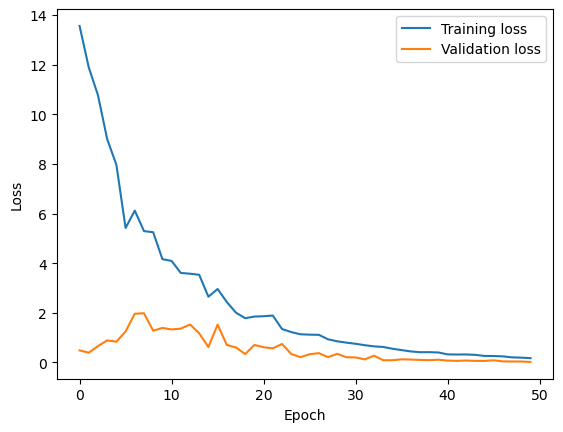

In [159]:
# Plot the training and validation loss as a function of the epoch
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

In [160]:
# Evaluate the model on the test set
y_pred = model.predict(X_test)
r2 = r2_score(y_test.flatten(), y_pred.flatten())
print("Test R2 score:", r2)

7/7 [==============================] - 0s 21ms/step
Test R2 score: 0.8963327114612233


In [161]:
m,b=np.polyfit(y_test.flatten(),y_pred.flatten(),1)
xs=np.linspace(-1,1,10)
ys=m*xs+b

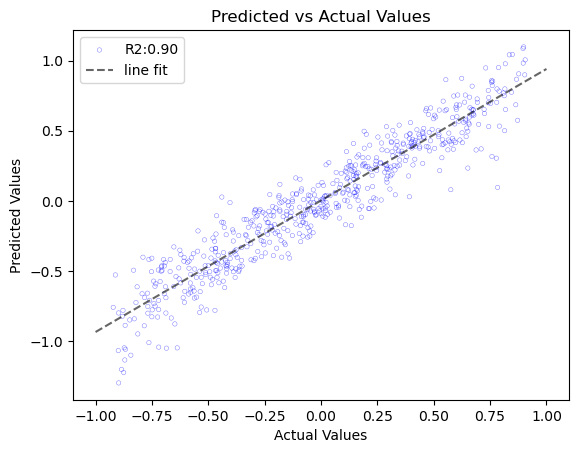

In [162]:
ax=sns.scatterplot(x=y_test.flatten(),y=y_pred.flatten(),marker='o',edgecolor='b',c='none',s=10,alpha=0.7,label='R2:%.2f'%r2)
ax=plt.plot(xs,ys,c='k',marker='none',linestyle='--',alpha=0.6,label='line fit')
ax=plt.legend()
ax=plt.xlabel('Actual Values')
ax=plt.ylabel('Predicted Values')
ax=plt.title('Predicted vs Actual Values')

should really do some more EDA on the actual data so that we can get some idea of predictive power but also 
how sensitive the model is to outliers  

0.2515738705682168
0.0936054103076458
42.08484649658203
0.001945657655596733


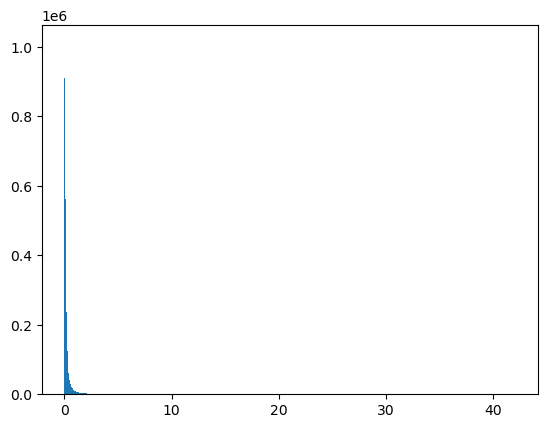

In [168]:
ax=plt.hist(X.flatten(),bins=1000)
print(np.mean(X.flatten()))
print(np.median(X.flatten()))
print(np.max(X.flatten()))
print(np.min(X.flatten()))

In [31]:
iconc=0.50 # spin concentration
cread=0    # reading correlation function from input file  otherwise it will be generated randomly 
'corr.in'
'jswitch.in'
icycles=200  # MC cycles 
ianneal=200  # MC input 

In [25]:

# np.shape(X_test[xvar].reshape((64,-1)))
# ax=imshow(np.flip(X_test[xvar].reshape((64,-1)),0),cmap='gray')

xvar=np.random.randint(0,np.shape(X_test)[0],1)[0]   
y_pred = model.predict(X_test)

y_pred[xvar]
# np.shape(X_test[xvar])
#imshow(np.transpose(occ2d),interpolation='nearest',cmap='gray')

7/7 [==============================] - 0s 7ms/step


array([ 0.16693419,  0.06219158, -0.75253963], dtype=float32)

In [30]:
def get_metrics_compare_regens_test_set(xvar,exp=1):   
    corr_in=y_test[xvar]
    corr_in=np.r_[1.0,corr_in]
    corr_out=np.loadtxt('./expfiles_%d/corr.out'%exp)
    imdat_0 = X_test[xvar].reshape((64,-1))
    imdat_1 = read_bin('./expfiles_%d/hk0.bin'%exp, npixels=64, offset=1280)
    
  #  print(corr_in, corr_out.flatten())
  #  print(np.shape(imdat_0)) 
  #  print(np.shape(imdat_1))
    r2c = r2_score(corr_in.flatten(), corr_out.flatten())
    msec=mean_squared_error(corr_in,corr_out.flatten())
    maec=mean_absolute_error(corr_in,corr_out.flatten())

    r2i=r2_score(imdat_0.flatten(),imdat_1.flatten())
    msei=mean_squared_error(imdat_0.flatten(),imdat_1.flatten())
    maei=mean_absolute_error(imdat_0.flatten(),imdat_1.flatten())
    return [r2c,msec,maec,r2i,msei,maei]    

# get_metrics_compare_regens_test_set(xvar,exp=1)

[0.28117244999472324,
 0.264057756967,
 0.2876345,
 -0.39090848549190094,
 0.3207671001317894,
 0.3282668561612354]

In [27]:
# Create a figure and axis for the plot
# Define a function to update the plot
def update_plot_regen(xvar):
    
    rows,cols =1,3 
    fig, axes = plt.subplots(rows, cols, figsize=(6,6))

   
    imdat = X_test[xvar].reshape((64,-1))
    axes[0].imshow(np.flip(imdat,0),cmap='gray')
    axes[0].axis("off")

    corrin=y_test[xvar]
    fhout=open('corr.in','w')
    fhout.write("%.6f %.6f\n%.6f %.6f\n"%(1.0,corrin[0],corrin[1],corrin[2]))
    fhout.close()
    calc_diffuse(iconc,1,icycles,ianneal,1) # do the regen on the image  
    
    occ3D=get_occ_map('./expfiles_1/ising2D_occ.txt')
    axes[1].imshow(np.transpose(occ3D[:,:,0]),interpolation='nearest',cmap='gray') 
    axes[1].axis("off")
    imdat = read_bin('./expfiles_1/hk0.bin', npixels=64, offset=1280)
    axes[2].imshow(np.flip(imdat,0),cmap='gray')
    axes[2].axis("off")
    
    my_metrics=get_metrics_compare_regens_test_set(xvar)
    fig.suptitle(" metrics(r2, mse, mae)\n corrfunc: %.3f, %.3f, %.3f \n FT_metrics: %.3f, %.3f, %.3f " %(tuple(my_metrics)), fontsize=10,y=0.73)
    

In [28]:
# Create a figure and axis for the plot
# Define a function to update the plot
def update_plot_ypred(xvar):
    rows,cols =1,3 
    fig, axes = plt.subplots(rows, cols, figsize=(6,6))
   
    imdat = X_test[xvar].reshape((64,-1))
    axes[0].imshow(np.flip(imdat,0),cmap='gray')
    axes[0].axis("off")

    corrin=y_pred[xvar]
    fhout=open('corr.in','w')
    fhout.write("%.6f %.6f\n%.6f %.6f\n"%(1.0,corrin[0],corrin[1],corrin[2]))
    fhout.close()
    calc_diffuse(iconc,1,icycles,ianneal,1) # do the regen on the image  
    
    occ3D=get_occ_map('./expfiles_1/ising2D_occ.txt')
    axes[1].imshow(np.transpose(occ3D[:,:,0]),interpolation='nearest',cmap='gray') 
    axes[1].axis("off")
    imdat = read_bin('./expfiles_1/hk0.bin', npixels=64, offset=1280)
    axes[2].imshow(np.flip(imdat,0),cmap='gray')
    axes[2].axis("off")
    
    my_metrics=get_metrics_compare_regens_test_set(xvar)
    fig.suptitle(" metrics(r2, mse, mae)\n corrfunc: %.3f, %.3f, %.3f \n FT_metrics: %.3f, %.3f, %.3f " %(tuple(my_metrics)), fontsize=10,y=0.73)
     

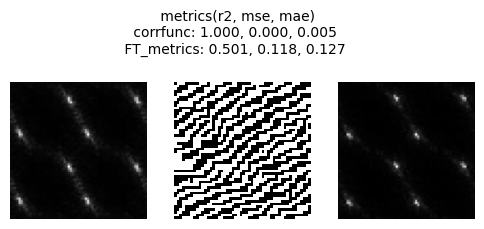

In [40]:
xvar=np.random.randint(0,np.shape(X_test)[0],1)[0]
update_plot_regen(xvar)   

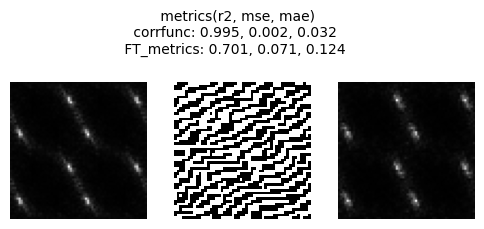

In [41]:
update_plot_ypred(xvar)  